In [1]:
import torch
from torch import distributions as dist
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from SBM_SDE import *
%matplotlib inline

# Load data

In [2]:
T = 500          # 100, 250, 500 length of actual time, full data contains T = 10,000
dt = .5          # .1, .2, .5 time gap between discretized time steps
N = int(T / dt)  # number of discretized time steps
N, T, dt

(1000, 500, 0.5)

In [3]:
y_dict = torch.load('y_dict.pt')
obs_times = torch.tensor(y_dict['t_y'][y_dict['t_y'] <= T], dtype=torch.float)
obs_vals = torch.tensor(y_dict['y'][:, y_dict['t_y'] <= T], dtype=torch.float).T # (time, obs_dim)
obs_errors = torch.tensor(y_dict['y_std'], dtype=torch.float)
obs_times.shape, obs_vals.shape, obs_errors.shape

(torch.Size([51]), torch.Size([51, 3]), torch.Size([3]))

In [4]:
state_ndim = obs_vals.shape[-1]
state_ndim

3

In [5]:
T_span = torch.linspace(0, T, N + 1)
T_span.shape

torch.Size([1001])

In [6]:
temp_ref = 283
temp_rise = 5 #High estimate of 5 celsius temperature rise by 2100. 

#System parameters from deterministic CON model
u_M = 0.002
a_SD = 0.33
a_DS = 0.33
a_M = 0.33
a_MSC = 0.5
k_S_ref = 0.000025
k_D_ref = 0.005
k_M_ref = 0.0002
Ea_S = 75
Ea_D = 50
Ea_M = 50

# Diffusion matrix parameters (variances, decrease)
sigma_S = 0.5
sigma_D = 0.001
sigma_M = 0.01

# Observation scale parameters (standard deviations, increase)
gamma_S, gamma_D, gamma_M = obs_errors.squeeze()

params = {'u_M': u_M, 'a_SD': a_SD, 'a_DS': a_DS, 'a_M': a_M, 'a_MSC': a_MSC,
          'k_S_ref': k_S_ref, 'k_D_ref': k_D_ref, 'k_M_ref': k_M_ref,
          'Ea_S': Ea_S, 'Ea_D': Ea_D, 'Ea_M': Ea_M,
          'sigma_S': sigma_S, 'sigma_D': sigma_D, 'sigma_M': sigma_M,
          'gamma_S': gamma_S, 'gamma_D': gamma_D, 'gamma_M': gamma_M} #, 'gamma_C': gamma_C

In [7]:
#Obtain temperature forcing function.
temp = temp_gen(T_span, temp_ref, temp_rise)

#Obtain SOC and DOC pool litter input vectors for use in flow SDE functions.
I_S = i_s(T_span) #Exogenous SOC input function
I_D = i_d(T_span) #Exogenous DOC input function
I_S.shape, I_D.shape

(torch.Size([1001]), torch.Size([1001]))

In [8]:
# Returns A, B, C, D, Q, R, and u for all time steps 0:T
def get_params_CO2(T_span, I_S, I_D, params, temp, temp_ref, state_ndim):
    # Apply temperature-dependent transformation to k_*_ref
    k_S = arrhenius_temp_dep(params['k_S_ref'], temp, params['Ea_S'], temp_ref) # (N, )
    k_D = arrhenius_temp_dep(params['k_D_ref'], temp, params['Ea_D'], temp_ref) # (N, )
    k_M = arrhenius_temp_dep(params['k_M_ref'], temp, params['Ea_M'], temp_ref) # (N, )
    
    # Rewrite drift vector alpha, s.t. x_prev + alpha * dt = A * x_prev + B * u
    A0 = torch.stack([-k_S, params['a_DS'] * k_D, params['a_M'] * params['a_MSC'] * k_M])
    A1 = torch.stack([params['a_SD'] * k_S, -(params['u_M'] + k_D), params['a_M'] * (1 - params['a_MSC']) * k_M])
    A2 = torch.stack([torch.zeros(N + 1), torch.ones(N + 1) * params['u_M'], -k_M])
    A = torch.stack([A0, A1, A2]).permute((2, 0, 1))
    A = torch.eye(state_ndim).unsqueeze(0) + A * dt # (N, 3, 3)
    
    B = torch.eye(state_ndim) # (3, 3)
    u = torch.stack([I_S, I_D, torch.zeros(N + 1)]).T * dt # (N, 3)
    
    # Rewrite diffusion matrix beta, s.t. beta * dt = Q
    Q = torch.diag(torch.tensor([params['sigma_S'],
                                 params['sigma_D'],
                                 params['sigma_M']])) * dt # (3, 3)
    
    C0 = torch.eye(state_ndim).unsqueeze(0) * torch.ones((len(k_S), 1, 1)) # (N, 3, 3)
    C1 = torch.stack([(1 - params['a_SD']) * k_S,
                      (1 - params['a_DS']) * k_D,
                      (1 - params['a_M']) * k_M]).unsqueeze(0).permute((2, 0, 1)) # (N, 1, 3) 
    C = torch.cat((C0, C1), dim=1) # (N, 4, 3)
    
    D = torch.zeros((state_ndim + 1, state_ndim)) # scalar
    R = torch.diag(torch.tensor([params['gamma_S'],
                                 params['gamma_D'],
                                 params['gamma_M'],
                                 params['gamma_C']]))**2 # (4, 4)
    
    return A, B, C, D, Q, R, u

In [9]:
# Returns A, B, C, D, Q, R, and u for all time steps 0:T
def get_params(T_span, I_S, I_D, params, temp, temp_ref, state_ndim):
    # Apply temperature-dependent transformation to k_*_ref
    k_S = arrhenius_temp_dep(params['k_S_ref'], temp, params['Ea_S'], temp_ref) # (N, )
    k_D = arrhenius_temp_dep(params['k_D_ref'], temp, params['Ea_D'], temp_ref) # (N, )
    k_M = arrhenius_temp_dep(params['k_M_ref'], temp, params['Ea_M'], temp_ref) # (N, )
    
    # Rewrite drift vector alpha, s.t. x_prev + alpha * dt = A * x_prev + B * u
    A0 = torch.stack([-k_S, params['a_DS'] * k_D, params['a_M'] * params['a_MSC'] * k_M])
    A1 = torch.stack([params['a_SD'] * k_S, -(params['u_M'] + k_D), params['a_M'] * (1 - params['a_MSC']) * k_M])
    A2 = torch.stack([torch.zeros(N + 1), torch.ones(N + 1) * params['u_M'], -k_M])
    A = torch.stack([A0, A1, A2]).permute((2, 0, 1))
    A = torch.eye(state_ndim).unsqueeze(0) + A * dt # (N, 3, 3)
    
    B = torch.eye(state_ndim) # (3, 3)
    u = torch.stack([I_S, I_D, torch.zeros(N + 1)]).T * dt # (N, 3)
    
    # Rewrite diffusion matrix beta, s.t. beta * dt = Q
    Q = torch.diag(torch.tensor([params['sigma_S'],
                                 params['sigma_D'],
                                 params['sigma_M']])) * dt # (3, 3)
    
    C = torch.eye(state_ndim).unsqueeze(0) * torch.ones((len(k_S), 1, 1)) # (N, 3, 3)
    #C1 = torch.stack([(1 - params['a_SD']) * k_S,
    #                  (1 - params['a_DS']) * k_D,
    #                  (1 - params['a_M']) * k_M]).unsqueeze(0).permute((2, 0, 1)) # (N, 1, 3) 
    #C = torch.cat((C0, C1), dim=1) # (N, 4, 3)
    
    D = torch.zeros((state_ndim, state_ndim)) #torch.zeros((state_ndim + 1, state_ndim)) # scalar
    R = torch.diag(torch.tensor([params['gamma_S'],
                                 params['gamma_D'],
                                 params['gamma_M']]))**2 # (3, 3)
    
    return A, B, C, D, Q, R, u

A, B, C, D, Q, R, u = get_params(T_span, I_S, I_D, params, temp, temp_ref, state_ndim)
print(A.shape, C.shape, u.shape)
print(B, D, Q, R)

torch.Size([1001, 3, 3]) torch.Size([1001, 3, 3]) torch.Size([1001, 3])
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]) tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]) tensor([[0.2500, 0.0000, 0.0000],
        [0.0000, 0.0005, 0.0000],
        [0.0000, 0.0000, 0.0050]]) tensor([[1.5762e+01, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 5.8375e-04, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.3778e-01]])


# Kalman filter

The model has 3 states (SOC, DOC, MBC) and 4 observations (SOC, DOC, MBC, CO2).

## Transition model

The transition distribution of the constant diffusion SCON model is given by:
$$p(\mathbf{x}_t | \mathbf{x}_{t-1}) = N(\mathbf{x}_t |
    \mathbf{x}_{t-1} + \alpha(\mathbf{x}_{t-1}, \boldsymbol{\theta_t}) \Delta t,
    \beta(\mathbf{x}_{t-1}, \boldsymbol{\theta_t}) \Delta t)$$

with drift vector $\alpha$:
$$
\alpha_t =
  \begin{bmatrix}
  I_S + a_{DS} \cdot k_D^{(t)} \cdot D + a_M \cdot a_{MSC} \cdot k_M^{(t)} \cdot M - k_S^{(t)} \cdot S \\
  I_D + a_{SD} \cdot k_S^{(t)} \cdot S + a_M \cdot (1 - a_{MSC}) \cdot k_M^{(t)} \cdot M - (u_M + k_D^{(t)}) \cdot D \\
  u_M \cdot D - k_M^{(t)} \cdot M
  \end{bmatrix}
$$

and diffusion matrix $\beta$:
$$
\beta_t =
  \begin{bmatrix}
  \sigma_S & 0 & 0 \\
  0 & \sigma_D & 0 \\
  0 & 0 & \sigma_M
  \end{bmatrix}
$$

To apply the Kalman filter, we require a linear function of the form:
$$ \mathbf{x}_t = \mathbf{A}_t \mathbf{x}_{t-1} + \mathbf{B}_t \mathbf{u}_t + \boldsymbol{\epsilon}_t$$

where $\boldsymbol{\epsilon}_t \sim N(\mathbf{0}, \mathbf{Q}_t)$ is a Gaussian system noise.

Rewriting the SCON transition model this way, we have:
- $\mathbf{A}_t = \mathbf{I} +
    \begin{bmatrix}
    - k_S^{(t)} & a_{DS} \cdot k_D^{(t)} & a_M \cdot a_{MSC} \cdot k_M^{(t)} \\
    a_{SD} \cdot k_S^{(t)} & -(u_M + k_D^{(t)}) & a_M \cdot (1 - a_{MSC}) \cdot k_M^{(t)}  \\
    0 & u_M & -k_M^{(t)}
    \end{bmatrix}\Delta t$
- $\mathbf{B}_t = \mathbf{I}$
- $\mathbf{u}_t=
    \begin{bmatrix}
    I_S \\
    I_D \\
    0 
    \end{bmatrix} \Delta t$
- $\mathbf{Q}_t = \beta_t \Delta t$

## Observation model

The observation distribution of the SCON model is:
$$p(\mathbf{y}_t|\mathbf{x}_t) = N(\mathbf{y}_t|\mathbf{x}_t, \mathbf{R}_t)$$

Expressing it as a linear function of the form: 
$$ \mathbf{y}_t = \mathbf{C}_t \mathbf{x}_{t} + \mathbf{D}_t \mathbf{u}_t + \boldsymbol{\delta}_t$$

where $\boldsymbol{\delta}_t \sim N(\mathbf{0}, \mathbf{R}_t)$ is a Gaussian observation noise, we have:
- $\mathbf{C}_t = \begin{bmatrix}
  1 & 0 & 0 \\
  0 & 1 & 0 \\
  0 & 0 & 1 \\
  (1 - a_{SD}) \cdot k_S^{(t)} & (1 - a_{DS}) \cdot k_D^{(t)} & (1 - a_M) \cdot k_M^{(t)}
  \end{bmatrix}$
- $\mathbf{D}_t = \mathbf{0}$
- $\mathbf{R}_t = \begin{bmatrix}
  \gamma_S & 0 & 0 & 0 \\
  0 & \gamma_D & 0 & 0 \\
  0 & 0 & \gamma_M & 0 \\
  0 & 0 & 0 & \gamma_C \\
  \end{bmatrix}$

In [10]:
class KalmanFilter:
    def __init__(self, A, B, C, D, Q, R, N, init_mu, init_sigma):
        # Parameters that are different across time
        self.A = A
        self.C = C
        
        # Parameters that are shared across time
        self.B = B
        self.D = D
        self.Q = Q
        self.R = R
        self.N = N
        self.state_ndim = len(init_mu)
        
        # Predictive parameters: Allocate for N + 1 time steps and initialize at time 0
        self.mu_pred = torch.empty((N + 1, self.state_ndim))
        self.sigma_pred = torch.empty((N + 1, self.state_ndim, self.state_ndim))
        self.mu_pred[0] = init_mu
        self.sigma_pred[0] = init_sigma
        
        # Filtered parameters
        self.mu_filter = torch.empty((N + 1, self.state_ndim))
        self.sigma_filter = torch.empty((N + 1, self.state_ndim, self.state_ndim))
        
        # Smoothed parameters
        self.mu_smooth = torch.empty((N + 1, self.state_ndim))
        self.sigma_smooth = torch.empty((N + 1, self.state_ndim, self.state_ndim))
        
    #def _get_param(self, param, i):
    #    if len(params) == 1:
    #        return param[0]
    #    else:
    #        return param[i]
        
    def forward(self, y, y_gap=None, u=None):
        if y_gap is None:
            y_gap = 1 # fully observed
        if u is None:
            u = torch.zeros((self.N + 1, self.state_ndim)) # no input/control signal
            
        for i in range(self.N + 1):
            if i > 0:
                self.predict(u[i], self.A[i], self.B, self.Q, i)
            
            y_i = y[int(i / y_gap)] if i % y_gap == 0 else None # is observed
            self.measure(y_i, u[i], self.C[i], self.D, self.R, i)
            
    def backward(self):
        # Initialize
        self.mu_smooth[self.N] = self.mu_filter[self.N]
        self.sigma_smooth[self.N] = self.sigma_filter[self.N]
        
        for i in range(self.N - 1, -1, -1):
            self.smooth(self.A[i+1], i)
        
    def predict(self, u, A, B, Q, i):
        self.mu_pred[i] = A @ self.mu_filter[i-1] + B @ u
        self.sigma_pred[i] = A @ self.sigma_filter[i-1] @ A.T + Q
        
    def measure(self, y, u, C, D, R, i):
        if y is not None:
            # Compute residual r
            y_hat = C @ self.mu_pred[i] + D @ u
            r = y - y_hat
            
            # Compute Kalman gain K
            S = C @ self.sigma_pred[i] @ C.T + R
            K = self.sigma_pred[i] @ C.T @ torch.inverse(S)
            
            # Update
            self.mu_filter[i] = self.mu_pred[i] + K @ r
            self.sigma_filter[i] = (torch.eye(self.state_ndim) - K @ C) @ self.sigma_pred[i]
        else:
            self.mu_filter[i] = self.mu_pred[i]
            self.sigma_filter[i] = self.sigma_pred[i]
        
    def smooth(self, A, i):
        # Compute backward Kalman gain J
        J = self.sigma_filter[i] @ A.T @ torch.inverse(self.sigma_pred[i+1])
        
        # Backward update
        self.mu_smooth[i] = self.mu_filter[i] + J @ (self.mu_smooth[i+1] - self.mu_pred[i+1])
        self.sigma_smooth[i] = self.sigma_filter[i] + J @ (self.sigma_smooth[i+1] - self.sigma_pred[i+1]) @ J.T

In [11]:
# Initial p(x0)
x0_mu = torch.tensor([40, 0.08, 0.8])
x0_sigma = torch.diag(0.1 * x0_mu)**2
x0_mu, x0_sigma

(tensor([40.0000,  0.0800,  0.8000]),
 tensor([[1.6000e+01, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 6.4000e-05, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 6.4000e-03]]))

In [12]:
obs_every = (obs_times[1] - obs_times[0]).item()
obs_every

10.0

In [13]:
kf = KalmanFilter(A, B, C, D, Q, R, N, init_mu=x0_mu, init_sigma=x0_sigma)
kf.forward(obs_vals, y_gap=obs_every/dt, u=u)
kf.backward()

# Visualizing the posterior

The *filtered* posterior is the distribution $p(x_t|y_{1:t'}, u_{1:t})$, where $t'$ is the time of the most recent observation. The *smoothed* posterior is the distribution $p(x_t|y_{1:T})$.

In [23]:
def plot_post(data, state_idx, plot_sd=False, show_legend=True, labels=['SOC', 'DOC', 'MBC']):
    #plt.figure(figsize=(7, 6))
    obs = data[:, state_idx]
    mean_filter = kf.mu_filter[:, state_idx]
    mean_smooth = kf.mu_smooth[:, state_idx]
    
    if plot_sd:
        sd_filter = kf.sigma_filter[:, state_idx, state_idx].sqrt()
        #rv_filter = dist.normal.Normal(mean_filter, sd_filter)
        #plt.fill_between(T_span, rv_filter.icdf(torch.tensor(0.05)), rv_filter.icdf(torch.tensor(0.95)),
        #                 alpha=0.5, linewidth=0,
        #                 label='Filtered 5-95th percentile')
        plt.fill_between(T_span, mean_filter - 2*sd_filter, mean_filter + 2*sd_filter, alpha=0.5,
                         linewidth=0, label='Filtered $\\mu \pm 2\sigma$')
        
        sd_smooth = kf.sigma_smooth[:, state_idx, state_idx].sqrt()
        #rv_smooth = dist.normal.Normal(mean_smooth, sd_smooth)
        #plt.fill_between(T_span, rv_smooth.icdf(torch.tensor(0.05)), rv_smooth.icdf(torch.tensor(0.95)),
        #                 alpha=0.5, linewidth=0,
        #                 label='Smoothed 5-95th percentile')
        plt.fill_between(T_span, mean_smooth - 2*sd_smooth, mean_smooth + 2*sd_smooth, alpha=0.5,
                         linewidth=0, label='Smoothed $\\mu \pm 2\sigma$')
        
    plt.plot(T_span, mean_filter, label='Filtered mean')
    plt.plot(T_span, mean_smooth, label='Smoothed mean')
    plt.plot(obs_times, obs, linestyle='None', marker='o', label='Observed')
    
    plt.xlabel('Hour')
    plt.ylabel(labels[state_idx])
    plt.title('True posterior $q(x|\\theta, y)$')
    if show_legend: plt.legend()

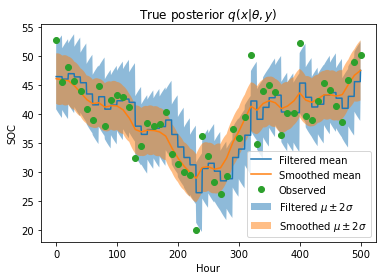

In [24]:
plot_post(obs_vals, 0, plot_sd=True)

In [ ]:
plot_post(obs_vals, 0)

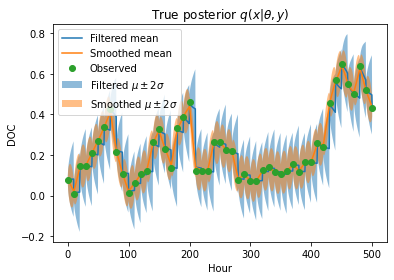

In [25]:
plot_post(obs_vals, 1, plot_sd=True)

In [ ]:
plot_post(obs_vals, 1)

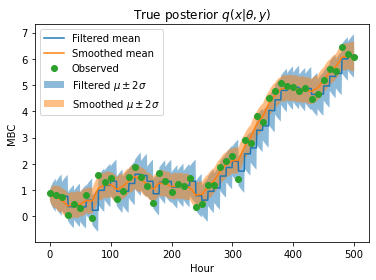

In [26]:
plot_post(obs_vals, 2, plot_sd=True)

In [ ]:
plot_post(obs_vals, 2)

## Testing the implementation: The constant velocity model

No need to worry about this part, it's for a different model! We used this for debugging purposes because we know the correct posterior for the model.

In [ ]:
import h5py

In [ ]:
sigma_v = 0.01
sigma_x = 0.01/3
sigma_y = 20

In [ ]:
track_file = h5py.File('track.mat', 'r')
track_file.keys()

In [ ]:
track_data = torch.tensor(track_file['data'], dtype=torch.float).squeeze()
track_data.shape

In [ ]:
mu0 = torch.tensor(track_file['x0'], dtype=torch.float).squeeze()
sigma0 = torch.tensor(track_file['P0'], dtype=torch.float)
mu0.shape, sigma0.shape

In [ ]:
T = len(track_data)
A = torch.tensor([[1, 1], [0, 1]], dtype=torch.float).unsqueeze(0) * torch.ones((T + 1, 1, 1))
Q = torch.tensor([[sigma_x, 0], [0, sigma_v]], dtype=torch.float)
C = torch.tensor([1, 0], dtype=torch.float).reshape((1, -1)).unsqueeze(0) * torch.ones((T + 1, 1, 1))
R = torch.tensor(sigma_y, dtype=torch.float)

In [ ]:
B, D = torch.eye(2), torch.ones(2)

In [ ]:
kf = KalmanFilter(A, B, C, D, Q, R, T - 1, init_mu=mu0, init_sigma=sigma0)
kf.forward(track_data)
kf.backward()

In [ ]:
T_span = torch.arange(100)
obs_times = torch.arange(100)
plot_post(track_data.unsqueeze(1), 0, plot_sd=True, labels=['State', 'State 2'])